In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import nltk
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
#listing availability
#predict price
#customer review analysis

In [62]:
def price_format(dtafrm,col):   
    """ accepts a dataframe, remove the "$" and convert the value type from string to float"""
    return (dtafrm[col].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

In [70]:
def rate_format(dtafrm,col):
    """accepts a dataframe, remove the "%" and convert the value type from string to float"""
    return (dtafrm[col].replace( '[\%,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

In [46]:
#calendar.csv
df_c= pd.read_csv("Seattle_Airbnb_calendar.csv")
df_c['newdate']= pd.to_datetime(df_c['date'])
df_c['DayOfWeek']= df_c['newdate'].dt.weekday_name
df_c['Month']=pd.DatetimeIndex(df_c['date']).month
df_c['available_transform'] = df_c['available'].map({'t': 1, 'f': 0})
df_c['DayofWeek_transform'] = df_c['DayOfWeek'].map({'Monday':1,'Tuesday':2,'Wednesday':3,
                                                     'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
df_c.head()

,listing_id,date,available,price,newdate,DayOfWeek,Month,available_transform,DayofWeek_transform
0,241032,2016-01-04,t,$85.00,2016-01-04,Monday,1,1,1
1,241032,2016-01-05,t,$85.00,2016-01-05,Tuesday,1,1,2
2,241032,2016-01-06,f,NaN,2016-01-06,Wednesday,1,0,3
3,241032,2016-01-07,f,NaN,2016-01-07,Thursday,1,0,4
4,241032,2016-01-08,f,NaN,2016-01-08,Friday,1,0,5


In [47]:
df_c['Year']=pd.DatetimeIndex(df_c['date']).year
df_c['Month_Year']=pd.to_datetime(df_c['date']).dt.to_period('M')

DayofWeek_transform
1    0.671101
2    0.671954
3    0.671793
4    0.669743
5    0.668911
6    0.667758
7    0.673001
Name: available_transform, dtype: float64


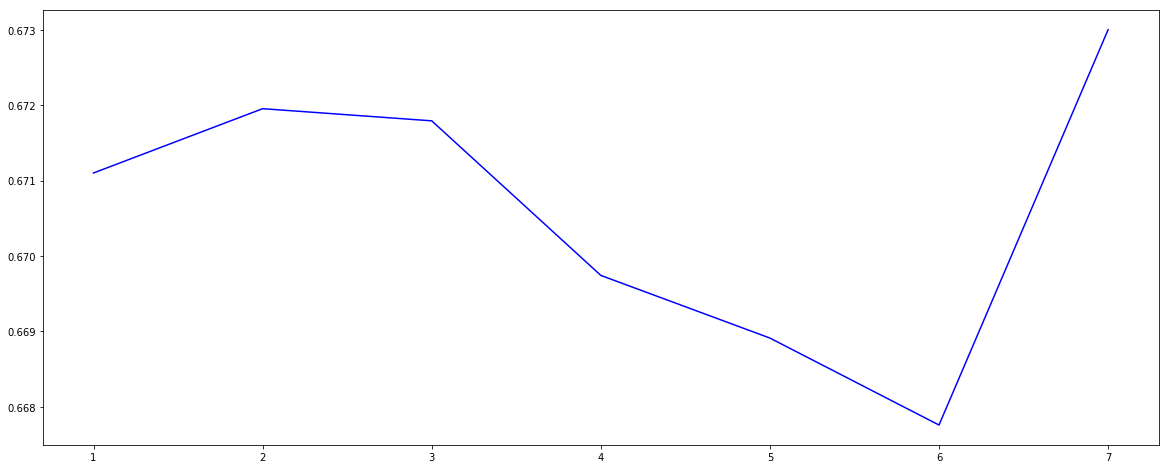

In [48]:
#listing availability by day of week
AvailabilityByWeekDay= df_c.groupby(['DayofWeek_transform'] )['available_transform'].sum()/df_c.groupby(['DayofWeek_transform'])['available_transform'].count()
print(AvailabilityByWeekDay)
plt.figure(figsize = (20,8))
plt.plot(AvailabilityByWeekDay,color='blue')

Month
1     0.566937
2     0.662208
3     0.709187
4     0.663847
5     0.675670
6     0.674384
7     0.627097
8     0.645051
9     0.674402
10    0.696514
11    0.713986
12    0.735573
Name: available_transform, dtype: float64


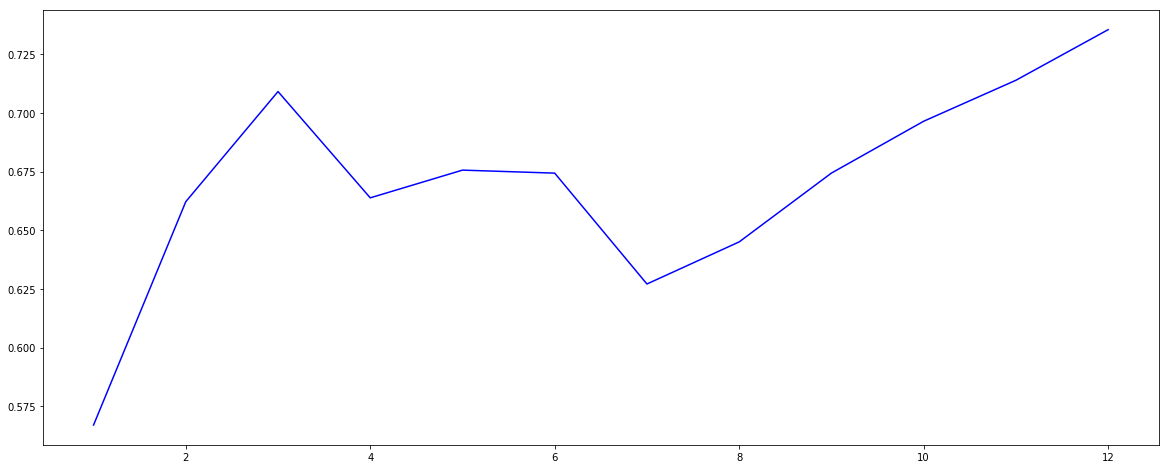

In [49]:
#listing availabiity by month
AvailabilityByMonth = df_c.groupby(['Month'])['available_transform'].sum()/df_c.groupby(['Month'])['available_transform'].count()
print(AvailabilityByMonth)
plt.figure(figsize = (20,8))
plt.plot(AvailabilityByMonth,color='blue')

In [9]:
#convert price format from string to float
df_c['price']= price_format(df_c)

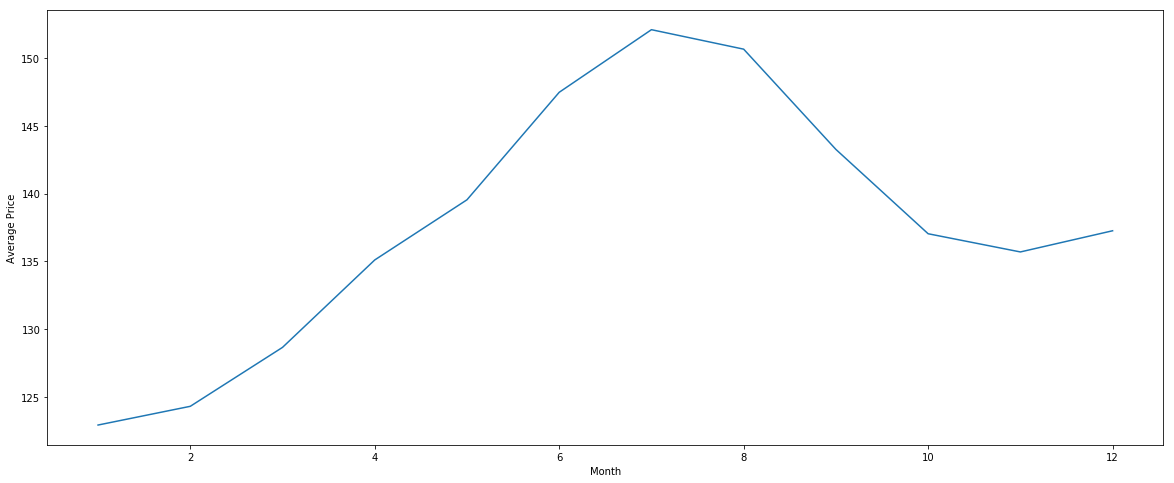

In [10]:
#what is the average price per month?
plt.figure(figsize = (20,8))
AvgPriceByMonth = df_c.groupby(['Month'])['price'].mean()
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.plot(AvgPriceByMonth )

In [57]:
#listings.csv
df_l= pd.read_csv("Seattle_Airbnb_listings.csv")
df_l.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [58]:
 df_l.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3818,3.818000e+03,3818,3818,3641,3249,3818,3818,2786,...,3162.000000,3818,0.0,3818,3818,3818,3818,3818,3818.000000,3191.000000
unique,NaN,3818,NaN,1,3792,3478,3119,3742,1,2506,...,NaN,1,NaN,1,2,3,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/5981343,NaN,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,...,NaN,f,NaN,WASHINGTON,f,strict,f,f,NaN,NaN
freq,NaN,1,NaN,3818,3,15,14,10,3818,17,...,NaN,3818,NaN,3818,3227,1417,3497,3443,NaN,NaN
mean,5.550111e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.452245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.946307,2.078919
std,2.962660e+06,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.893029,1.822348
min,3.335000e+03,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.020000
25%,3.258256e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.695000
50%,6.118244e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.540000
75%,8.035127e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,3.000000


In [59]:
df_l.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [60]:
#check if id only contains unique values
pd.Series(df_l['id']).is_unique

True

In [85]:
#convert price type from string to float
df_l['price']= price_format(df_l,'price')

In [15]:
df_l['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

In [16]:
df_l['price'].var()
df_l['price'].std()
df_l['price'].skew()

3.113122670038106

Text(0,0.5,'Frequency')

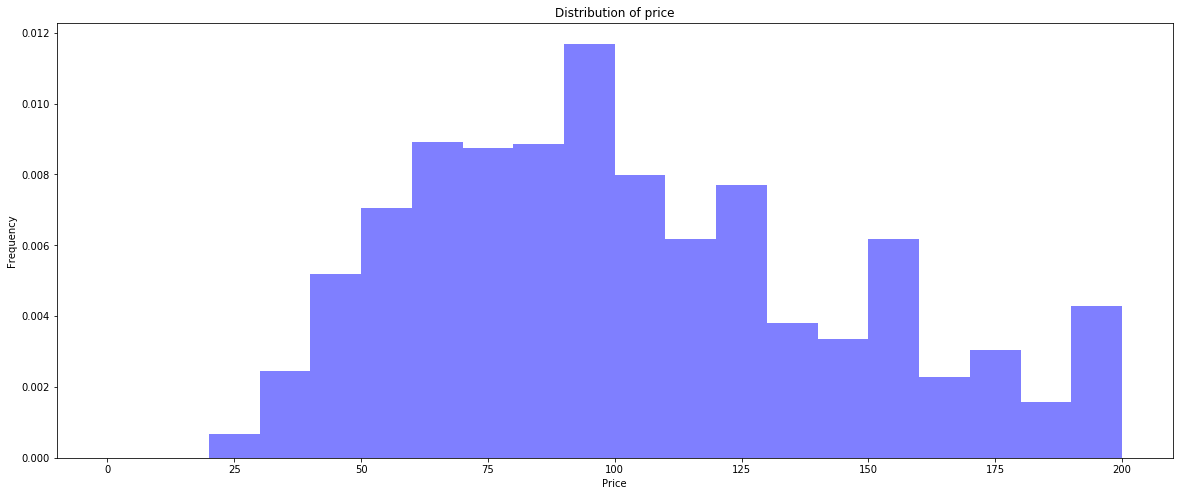

In [17]:
#Distribution of price
plt.figure(figsize = (20,8))
plt.hist(df_l['price'], bins=20, normed=True, alpha=0.5,
         histtype='stepfilled', color='blue',
         edgecolor='none',range=(0,200));
plt.title('Distribution of price')
plt.xlabel('Price')
plt.ylabel('Frequency')

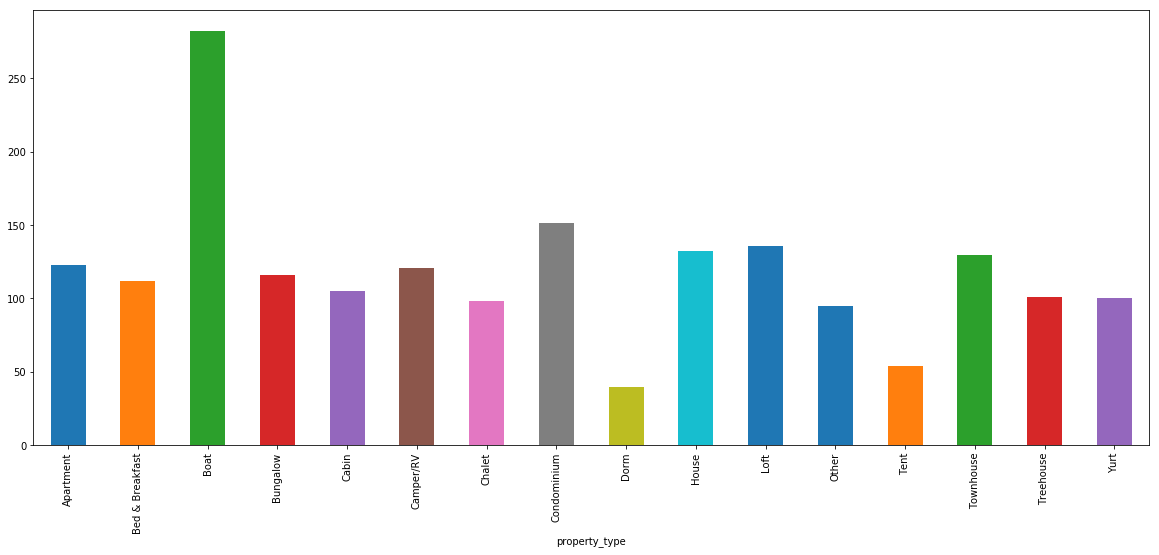

In [15]:
#avg price by property_type
plt.figure(figsize = (20,8))
df_l.groupby('property_type')['price'].mean().plot(kind='bar')
plt.show()

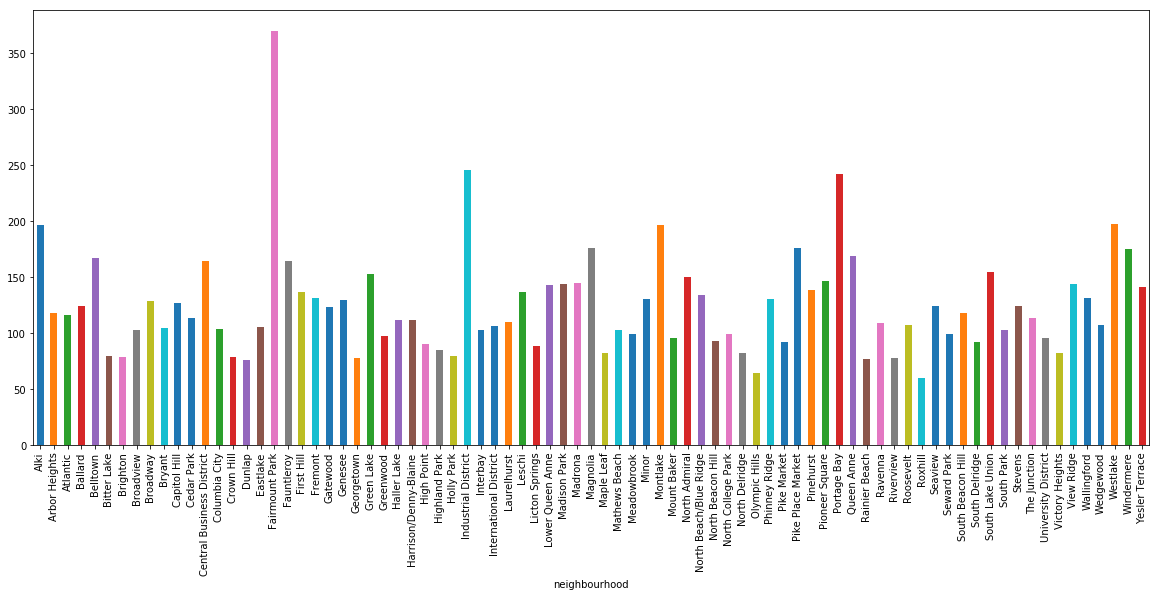

In [17]:
#avg price by neighbourhood
plt.figure(figsize = (20,8))
df_l.groupby('neighbourhood')['price'].mean().plot(kind='bar')
plt.show()

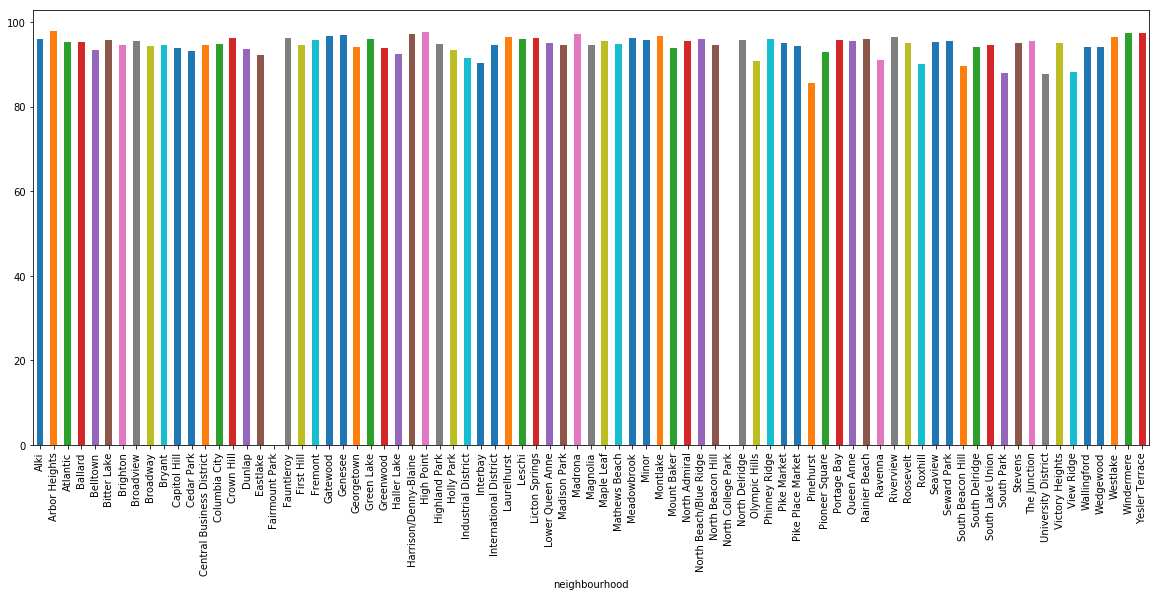

In [18]:
#avg review score by neighbourhood
plt.figure(figsize = (20,8))
df_l.groupby('neighbourhood')['review_scores_rating'].mean().plot(kind='bar')
plt.show()

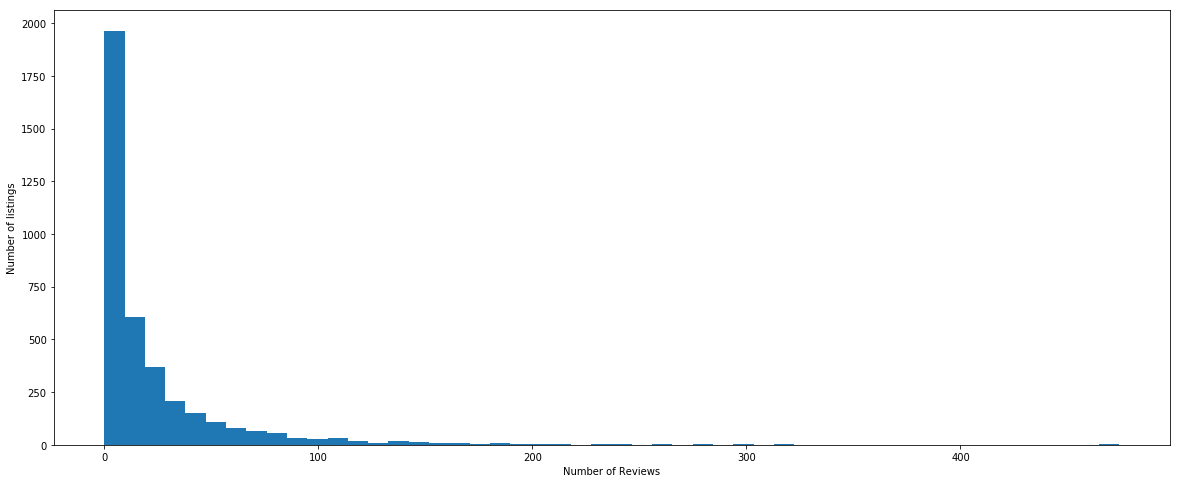

In [24]:
#distribution of avg number of reviews by id?
plt.figure(figsize = (20,8))
df_l.groupby('id')['number_of_reviews'].mean().plot(kind='hist',bins=50)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of listings')
plt.show()

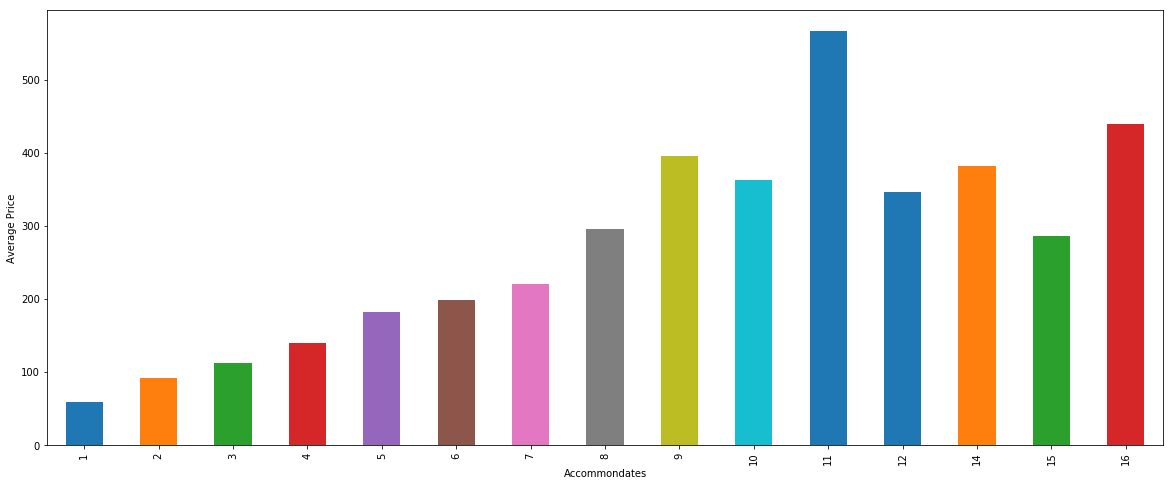

In [18]:
#What is the average price for each accommodates type?
plt.figure(figsize=(20,8))
df_l.groupby(['accommodates'])['price'].mean().plot(kind='bar')
plt.xlabel('Accommondates')
plt.ylabel('Average Price')
plt.show()


In [66]:
#data preparation --predict listing price
df = df_l[["host_response_rate", "host_acceptance_rate", "host_is_superhost",
               "host_listings_count", "neighbourhood", "zipcode", "property_type","room_type", "accommodates", "bathrooms", "bedrooms", 
               "beds", "price", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]

In [67]:
#proportion missing value 
df.isnull().sum()/df.shape[0]

host_response_rate      0.136983
host_acceptance_rate    0.202462
host_is_superhost       0.000524
host_listings_count     0.000524
neighbourhood           0.108958
zipcode                 0.001833
property_type           0.000262
room_type               0.000000
accommodates            0.000000
bathrooms               0.004191
bedrooms                0.001572
beds                    0.000262
price                   0.000000
number_of_reviews       0.000000
review_scores_rating    0.169460
cancellation_policy     0.000000
reviews_per_month       0.164222
dtype: float64

In [ ]:
#since the missing valuess are relatively low (<30%), we can drop the missing values

In [68]:
# drop NaN rows
df2=df.dropna(axis=0)

In [71]:
pd.options.mode.chained_assignment = None  #default='warn'

df2['host_response_rate'] = rate_format(df2,'host_response_rate') #convert to string
df2['host_acceptance_rate'] = rate_format(df2,'host_acceptance_rate')
df2['price'] = price_format(df2,'price')

In [72]:
df2['superhost']=np.where(df2['host_is_superhost']=='t',1,0) #map 't' and 'f' to be 1 and 0 
del df2['host_is_superhost']

In [73]:
# select non-numeric variables and create dummies
non_num_vars = df2.select_dtypes(include=['object']).columns

In [74]:
dummy_vars = pd.get_dummies(df2[non_num_vars])

In [75]:
# drop non-numeric variables from df2 and add the dummies
df3=df2.drop(non_num_vars,axis=1)
df3 = pd.merge(df3,dummy_vars, left_index=True, right_index=True)

In [77]:
#random forest
x = df3.drop('price', axis =1)
y = df3['price']
feature_list = np.array(x.columns)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
rf.fit(X_train, y_train)

#calculate scores for the model
y_train_preds = rf.predict(X_train)
y_test_preds = rf.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 381.267, test: 2196.343
Random Forest R^2 train: 0.946, test: 0.658


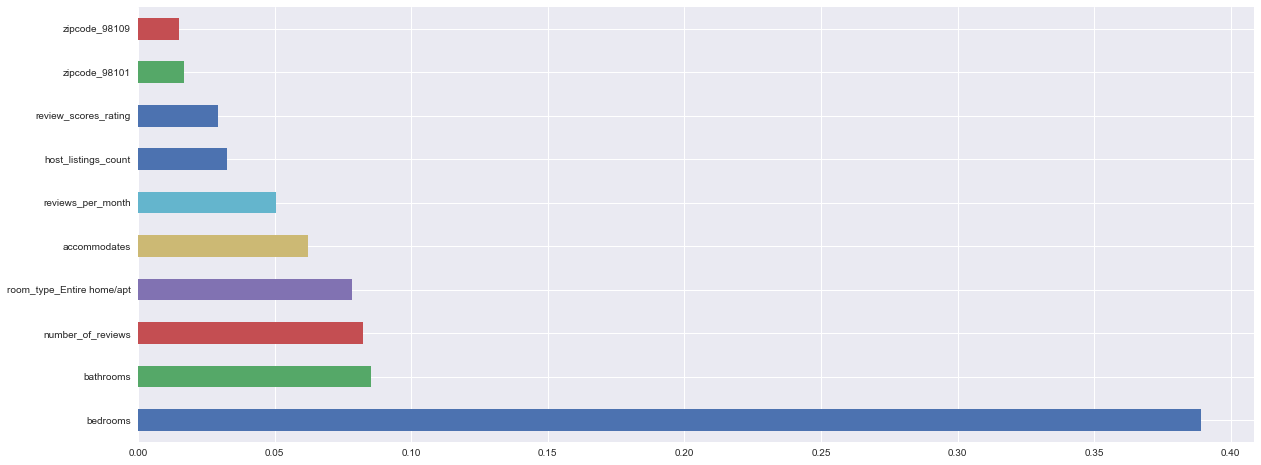

In [61]:
# plot feature importance
plt.figure(figsize=(20,8))
feat_importances = pd.Series(rf.feature_importances_, index=feature_list)
feat_importances.nlargest(10).plot(kind='barh')

In [78]:
#import reviews
df_r= pd.read_csv('Seattle_Airbnb_reviews.csv',encoding='utf-8')
df_r.head()
df_r.shape

(84849, 6)

In [79]:
df_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [80]:
df_r['comments'].isnull().sum()

18

In [81]:
df_r=df_r.dropna(subset=['comments'])

In [83]:
df_r['Month_Year']=pd.to_datetime(df_r['date']).dt.to_period('M')

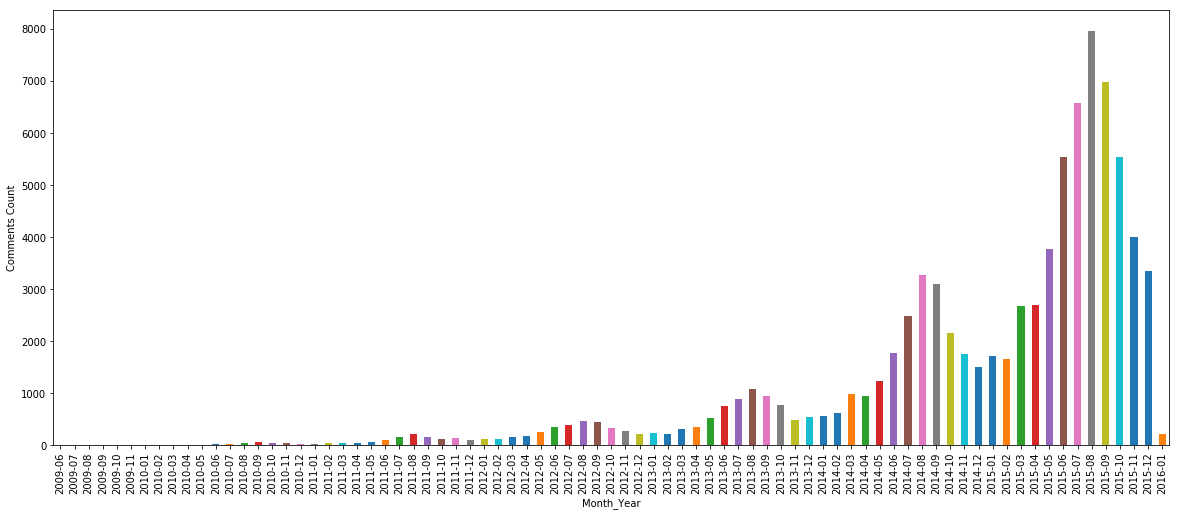

In [84]:
# what's the distribution of reviews over time
plt.figure(figsize=(20,8))
df_r.groupby(['Month_Year'])['reviewer_id'].count().plot(kind='bar')
plt.xlabel('Month_Year')
plt.ylabel('Comments Count')
plt.show()

In [52]:
# SentimentAnalyzer can implement and facilitate sentiment analysis tasks with NLTK algorithms and features
#There are four types of score: negative, neutral, positive and compound. By using apply() and lambda
#we could transform the result and put them into the “reviews” data frame
sid = SentimentIntensityAnalyzer()
df_r['neg'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['neg'])
df_r['neu'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['neu'])
df_r['pos'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['pos'])
df_r['compound'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [54]:
df_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Month_Year,neg,neu,pos,compound
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,2015-07,0.000,0.462,0.538,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,2015-07,0.000,0.609,0.391,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",2015-07,0.043,0.772,0.185,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,2015-08,0.035,0.765,0.200,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,2015-08,0.000,0.655,0.345,0.9783


In [56]:
#Here we could set the threshold of the compound score as ±0.2. 
#If the compound score of a review is greater than 0.2, then the review is positive. 
#If the compound score of a review is less than 0.2, then the review is negative. 
#If the compound score is between -0.2 and 0.2, then the review is neural.
pos_comments = 0
neu_comments = 0
neg_comments = 0
for index, row in df_r.iterrows(): 
    if(row['compound']>0.2):
        pos_comments += 1
    if(0.2>= row['compound']>= -0.2):
        neu_comments += 1
    if (row['compound']<-0.2):
        neg_comments += 1
       

In [58]:
print('Percentage of positive review: {}%'.format((pos_comments)*100/len(df_r['comments'])))
print('Percentage of neutral review: {}%'.format((neu_comments)*100/len(df_r['comments'])))
print('Percentage of nwgative review: {}%'.format((neg_comments)*100/len(df_r['comments'])))

Percentage of positive review: 96.9374403225236%
Percentage of neutral review: 2.2574294774315993%
Percentage of nwgative review: 0.805130200044795%


In [ ]:
#From the above chart, we can conclude 96.9% of the reviews are positive and only 1.8% of the reviews are negative. 
#Based on the analysis, it is safe to say that seattle airbnb is a well-liked vocation rental